In [1]:
from matplotlib import pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
rc('text', usetex=False)
import scipy.stats as stats
from sklearn.preprocessing import minmax_scale
from pymer4.models import Lmer, Lm
from statsmodels.tsa.ar_model import AutoReg
import seaborn as sns
import numpy as np
import pandas as pd
import os

In [2]:
homeDir = '/demos' #'path to home folder'

# Specify where the data are
datDir =  f'{homeDir}/behav_demo_data'
# Specify output folder for data
outDir = f'{homeDir}/demo_output'
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [3]:
subList = ['s001',
           's002',
           's003',
           's004',
           's005',
           's006',
           's007',
           's008',
           's009',
           's010']
# Some subIDs are repeated because they have multiple blocks of data
blockList = [['b01'],
             ['b01','b02'],
             ['b01'],
             ['b01','b02'],
             ['b01','b02'],
             ['b01','b02'],
             ['b01','b02'],
             ['b01','b02'],
             ['b01'],
             ['b01']]

In [4]:
# Loop through subjects and blocks
group_reportAcc = []
group_timeAcc = []
groupData = []
groupData_L1 = []
groupData_L2 = []

for subIdx, subID in enumerate(subList):    
    subData = []
    subData_L1 = []
    subData_L2 = []
    for blockIdx in np.arange(len(blockList[subIdx])):
        blockID = blockList[subIdx][blockIdx]
        
        # Load in data
        blockData = pd.read_csv(f'{datDir}/{subID}_{blockID}.csv')
        subjectID = subID.split('s')[1]
        blockData['subID'] = int(subjectID)      
        blockData['trialNo'] = np.arange(len(blockData))
        blockData['catTrial'] = pd.qcut(blockData.trialNo, 3, retbins = False, labels=['early','middle','late'])
        blockData = blockData.dropna(subset=['respKey_Guess','isCorrectReport'],axis=0)
        blockData['blockIdx'] = blockIdx
        
        # Encode stay vs switch
        prevGuess = np.roll(blockData.resp_Guess,1)
        blockData['switch'] = (blockData.resp_Guess != prevGuess).astype(int)
        
        # Recode guess choice and L/R
        blockData['guessLower'] = blockData.resp_Guess - 1
        blockData['guessLRight'] = blockData.respKey_Guess - 1
                        
        # Define prev trial variables 
        blockData['prevTrial_EV']= np.roll(blockData.p1,1)
        blockData['prevTrial_ERisk']= np.roll(blockData.riskP2,1)
        blockData['prevTrial_riskPE']= np.roll(blockData.peRiskP2,1)
        blockData['prevTrial_RPE']= np.roll(blockData.peP2,1)
        blockData['prevTrialOut_L1'] = np.roll(blockData.p2,1)        
        blockData_L1 = blockData.iloc[1:,:]
        
        # Define prev guess and keypress L/R 
        blockData['guessLower_L1'] = np.roll(blockData.guessLower, 1)
        blockData['guessLower_L2'] = np.roll(blockData.guessLower, 2)        
        blockData['guessLRight_L1'] = np.roll(blockData.guessLRight, 1)
        blockData['guessLRight_L2'] = np.roll(blockData.guessLRight, 2)        
        blockData_L2 = blockData.iloc[2:,:]

        # Append to subData
        subData.append(blockData)
        subData_L1.append(blockData_L1)
        subData_L2.append(blockData_L2)
    
    # Create subject dataframe
    subData = pd.concat(subData)
    subData_L1 = pd.concat(subData_L1)
    subData_L2 = pd.concat(subData_L2)
    
    # Append to group data
    groupData.append(subData)
    groupData_L1.append(subData_L1)
    groupData_L2.append(subData_L2)
    
    
    # Compute report accuracy
    isCorrectReport = subData.isCorrectReport
    perc_reportAcc = np.divide(np.nansum(isCorrectReport),len(isCorrectReport)) * 100
    group_reportAcc.append(perc_reportAcc)
        
    # Does report accuracy decrease over time
    group_tertAcc = np.empty(3,dtype=float)
    for tertIdx, tertile in enumerate(['early','middle','late']):
        tertData = subData[subData['catTrial'] == tertile]
        tertReport = tertData.isCorrectReport
        perc_reportTertAcc = np.divide(np.nansum(tertReport),len(tertReport)) * 100
        group_tertAcc[tertIdx] = perc_reportTertAcc
    group_timeAcc.append(group_tertAcc)        

# Create group DFs
groupData = pd.concat(groupData)
groupData_L1 = pd.concat(groupData_L1)
groupData_L2 = pd.concat(groupData_L2)

In [5]:
mean_acc = np.mean(group_reportAcc)
sd_acc = np.std(group_reportAcc)
sem_acc = stats.sem(group_reportAcc)

In [6]:
# Create vector for re-centered (against 0.5) DV
groupData['isCorrectReport_mc'] = groupData['isCorrectReport'] - 0.5
# Specify lme version of one-sample t-test
ephys_mod_chance = Lmer("isCorrectReport_mc ~ 1 + (1|subID) ", 
                        data=groupData, 
                        family='gaussian')
res = ephys_mod_chance.fit()
display(res)

/home/vman/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


             Estimate    2.5_ci   97.5_ci        SE        DF     T-stat  \
(Intercept)  0.414589  0.358153  0.471026  0.028795  9.266212  14.398085   

                    P-val  Sig  
(Intercept)  1.183740e-07  ***  
Linear mixed model fit by REML [’lmerMod’]
Formula: isCorrectReport_mc~1+(1|subID)

Family: gaussian	 Inference: parametric

Number of observations: 1309	 Groups: {'subID': 10.0}

Log-likelihood: -168.999 	 AIC: 343.997

Random effects:

                 Name    Var    Std
subID     (Intercept)  0.008  0.087
Residual               0.074  0.272

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.415,0.358,0.471,0.029,9.266,14.398,0.0,***


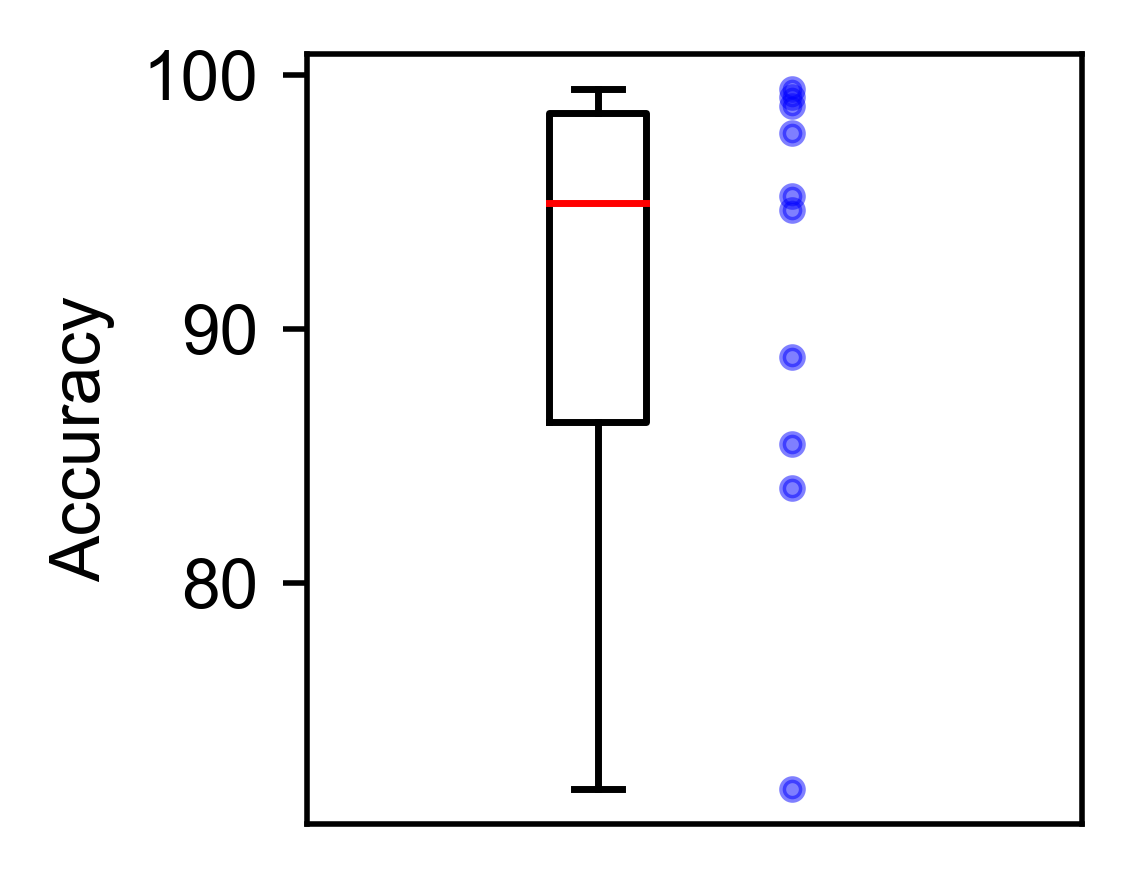

In [7]:
fig, ax = plt.subplots(figsize=(2,2), dpi=500)
# Plot ephys group
# Draw 
ax.scatter(x=np.ones(len(group_reportAcc)) * 0.05, y=group_reportAcc, color='blue', s=8, alpha=0.5)
ax.boxplot(group_reportAcc, positions=[-0.05], 
           widths=0.05, showfliers=True, 
           boxprops=dict(color='black'),
           medianprops = dict(color='red'))

ax.set_xticks([]); 
ax.set_xlim([-0.2, 0.2])
ax.set_ylabel('Accuracy')

fig.savefig(f'{outDir}/fig1_reportacc.svg')

In [8]:
group_timeAccDF = pd.melt(pd.DataFrame({'early':np.array([group_timeAcc[i][0] for i in np.arange(len(group_timeAcc))]),
                                'mid':np.array([group_timeAcc[i][1] for i in np.arange(len(group_timeAcc))]),
                                'late':np.array([group_timeAcc[i][2] for i in np.arange(len(group_timeAcc))])
                                }))
group_timeAccDF.columns = ['time','reportAcc']

In [9]:
groupData['trialNo'] = minmax_scale(groupData['trialNo'] )
ephys_mod_time = Lmer("isCorrectReport ~ trialNo + (1+trialNo|subID)", 
                data=groupData, family='binomial')
ephys_time = ephys_mod_time.fit()
display(ephys_time)

/home/vman/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


             Estimate    2.5_ci   97.5_ci        SE         OR  OR_2.5_ci  \
(Intercept)  3.630366  2.570898  4.689834  0.540555  37.726620  13.077565   
trialNo     -1.272406 -2.671638  0.126826  0.713907   0.280157   0.069139   

             OR_97.5_ci      Prob  Prob_2.5_ci  Prob_97.5_ci    Z-stat  \
(Intercept)  108.835087  0.974178     0.928965      0.990895  6.716001   
trialNo        1.135220  0.218846     0.064668      0.531664 -1.782313   

                    P-val  Sig  
(Intercept)  1.867800e-11  ***  
trialNo      7.469820e-02    .  
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: isCorrectReport~trialNo+(1+trialNo|subID)

Family: binomial	 Inference: parametric

Number of observations: 1309	 Groups: {'subID': 10.0}

Log-likelihood: -337.754 	 AIC: 685.509

Random effects:

              Name    Var    Std
subID  (Intercept)  1.713  1.309
subID      trialNo  1.405  1.185

               IV1      IV2   Corr
subID  (Intercept)  trialNo -0.376

Fixed effec

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),3.630,2.571,4.690,0.541,37.727,13.078,108.835,0.974,0.929,0.991,6.716,0.000,***
trialNo,-1.272,-2.672,0.127,0.714,0.280,0.069,1.135,0.219,0.065,0.532,-1.782,0.075,.


In [10]:
ephys_mod_guess = Lmer("guessLower ~ prevTrial_EV + prevTrial_RPE + prevTrial_ERisk + prevTrial_riskPE + (1+prevTrial_EV + prevTrial_RPE + prevTrial_ERisk + prevTrial_riskPE |subID)", 
                data=groupData_L1, family='binomial')
ephys_guess = ephys_mod_guess.fit()
display(ephys_guess)

/home/vman/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


boundary (singular) fit: see help('isSingular') 

                  Estimate    2.5_ci   97.5_ci        SE        OR  OR_2.5_ci  \
(Intercept)      -0.159499 -0.387713  0.068715  0.116438  0.852571   0.678607   
prevTrial_EV     -0.103626 -0.310822  0.103570  0.105714  0.901562   0.732844   
prevTrial_RPE    -0.010118 -0.172816  0.152580  0.083011  0.989933   0.841292   
prevTrial_ERisk   0.138389 -0.183858  0.460636  0.164415  1.148422   0.832054   
prevTrial_riskPE  0.159495 -0.095617  0.414606  0.130161  1.172918   0.908812   

                  OR_97.5_ci      Prob  Prob_2.5_ci  Prob_97.5_ci    Z-stat  \
(Intercept)         1.071131  0.460210     0.404268      0.517172 -1.369821   
prevTrial_EV        1.109123  0.474117     0.422914      0.525869 -0.980250   
prevTrial_RPE       1.164836  0.497471     0.456903      0.538071 -0.121888   
prevTrial_ERisk     1.585081  0.534542     0.454165      0.613165  0.841708   
prevTrial_riskPE    1.513774  0.539789     0.476114      0.602192  1

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.159,-0.388,0.069,0.116,0.853,0.679,1.071,0.460,0.404,0.517,-1.370,0.171,
prevTrial_EV,-0.104,-0.311,0.104,0.106,0.902,0.733,1.109,0.474,0.423,0.526,-0.980,0.327,
prevTrial_RPE,-0.010,-0.173,0.153,0.083,0.990,0.841,1.165,0.497,0.457,0.538,-0.122,0.903,
prevTrial_ERisk,0.138,-0.184,0.461,0.164,1.148,0.832,1.585,0.535,0.454,0.613,0.842,0.400,
prevTrial_riskPE,0.159,-0.096,0.415,0.130,1.173,0.909,1.514,0.540,0.476,0.602,1.225,0.220,


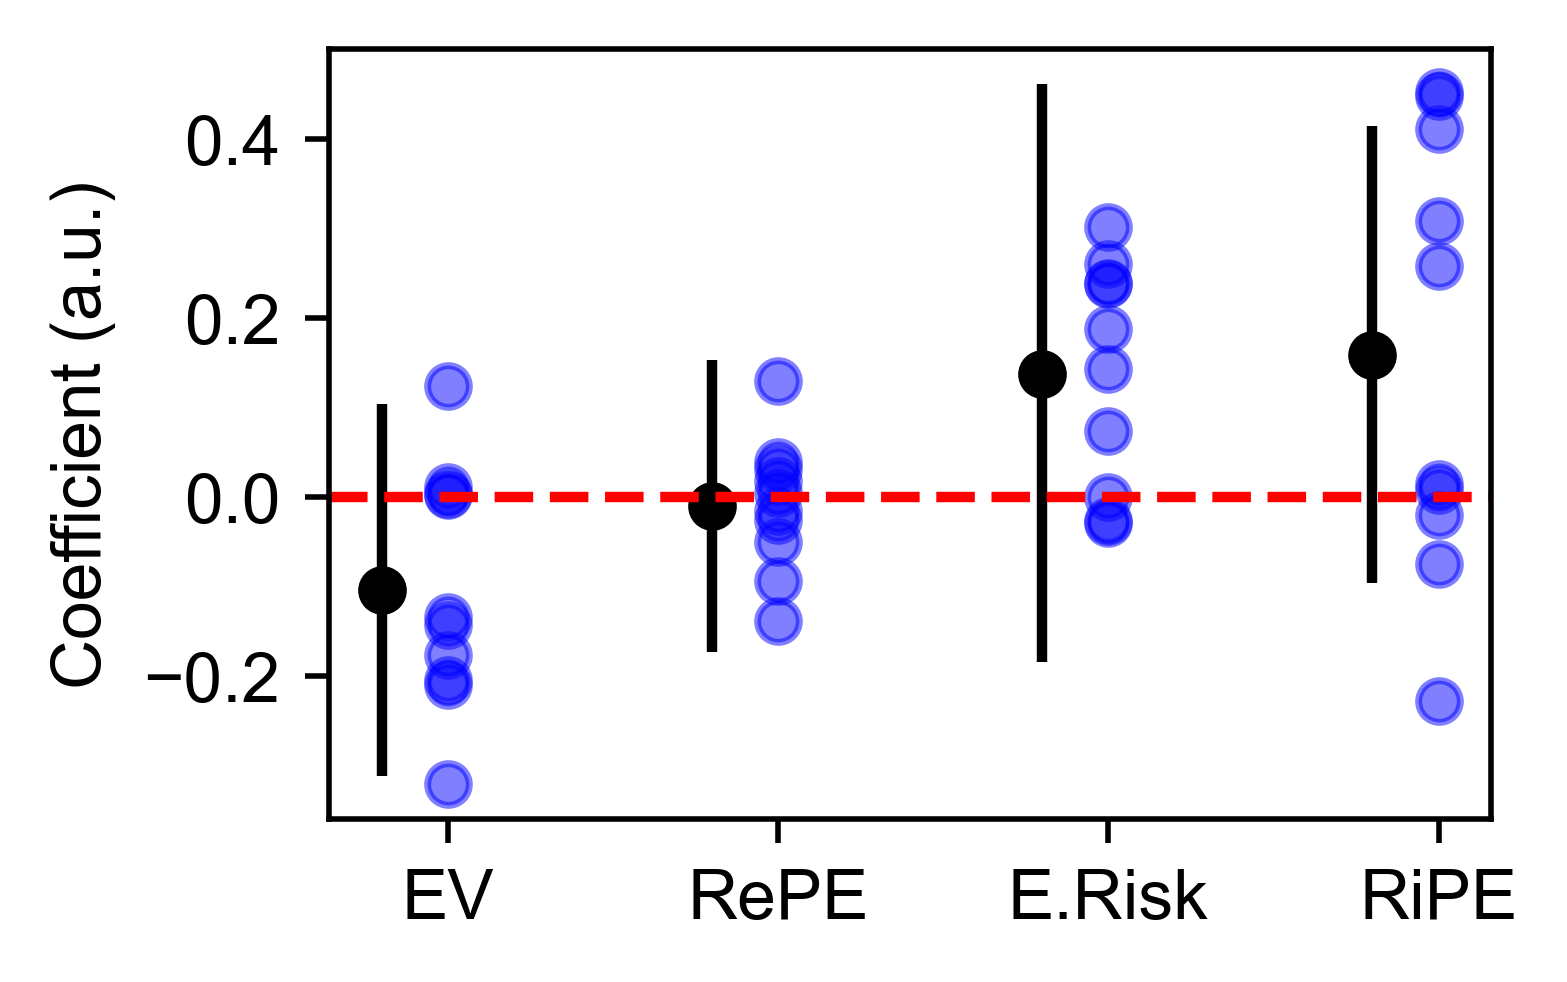

In [11]:
# Create array of lower and upper CI
CI_array = np.array([ephys_guess.Estimate[1:].values - ephys_guess['2.5_ci'][1:].values,
                     ephys_guess['97.5_ci'][1:].values - ephys_guess.Estimate[1:].values])


fig, ax = plt.subplots(figsize=(3,2), dpi=500, sharey=True)
ax.scatter(x=np.arange(4)-0.2, y=ephys_guess.Estimate[1:].values, color='black')
ax.errorbar(x = np.arange(4)-0.2, y = ephys_guess.Estimate[1:].values,
            yerr = CI_array,
             ls='none', color='black')
ax.scatter(x = np.ones(ephys_mod_guess.fixef.shape[0]) * 0, y=ephys_mod_guess.fixef['prevTrial_EV'], color='blue', alpha=0.5)             
ax.scatter(x = np.ones(ephys_mod_guess.fixef.shape[0]), y=ephys_mod_guess.fixef['prevTrial_RPE'], color='blue', alpha=0.5 )             
ax.scatter(x = np.ones(ephys_mod_guess.fixef.shape[0]) * 2, y=ephys_mod_guess.fixef['prevTrial_ERisk'], color='blue', alpha=0.5 )             
ax.scatter(x = np.ones(ephys_mod_guess.fixef.shape[0]) * 3, y=ephys_mod_guess.fixef['prevTrial_riskPE'], color='blue', alpha=0.5 )             

ax.axhline(0,color='red',linestyle='--')
ax.set_xticks(np.arange(4))
ax.set_xticklabels(['EV','RePE','E.Risk',r'RiPE'],fontsize=10)
ax.set_ylabel('Coefficient (a.u.)')

fig.savefig(f'{outDir}/fig1_guessmod_coef.svg')

In [12]:
ephys_mod_switch = Lmer("switch ~ prevTrialOut_L1 + (1+prevTrialOut_L1|subID)", 
                data=groupData_L1, family='binomial')
ephys_switch = ephys_mod_switch.fit()
display(ephys_switch)

/home/vman/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


boundary (singular) fit: see help('isSingular') 

                 Estimate    2.5_ci   97.5_ci        SE        OR  OR_2.5_ci  \
(Intercept)      0.030631 -0.101785  0.163048  0.067561  1.031105   0.903224   
prevTrialOut_L1 -0.102995 -0.220444  0.014454  0.059924  0.902132   0.802163   

                 OR_97.5_ci      Prob  Prob_2.5_ci  Prob_97.5_ci    Z-stat  \
(Intercept)        1.177093  0.507657     0.474576      0.540672  0.453389   
prevTrialOut_L1    1.014559  0.474274     0.445111      0.503613 -1.718758   

                    P-val Sig  
(Intercept)      0.650269      
prevTrialOut_L1  0.085658   .  
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: switch~prevTrialOut_L1+(1+prevTrialOut_L1|subID)

Family: binomial	 Inference: parametric

Number of observations: 1293	 Groups: {'subID': 10.0}

Log-likelihood: -893.909 	 AIC: 1797.817

Random effects:

                  Name    Var    Std
subID      (Intercept)  0.012  0.111
subID  prevTrialOut_L1  0.004  0

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),0.031,-0.102,0.163,0.068,1.031,0.903,1.177,0.508,0.475,0.541,0.453,0.650,
prevTrialOut_L1,-0.103,-0.220,0.014,0.060,0.902,0.802,1.015,0.474,0.445,0.504,-1.719,0.086,.


In [13]:
perSub_meanDF = groupData_L1.groupby(['subID', 'prevTrialOut_L1'], as_index=False).mean()
loss_DF = perSub_meanDF[perSub_meanDF.prevTrialOut_L1 == -1]
win_DF = perSub_meanDF[perSub_meanDF.prevTrialOut_L1 == 1]

<ipython-input-13-951e9d864aa9>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  perSub_meanDF = groupData_L1.groupby(['subID', 'prevTrialOut_L1'], as_index=False).mean()


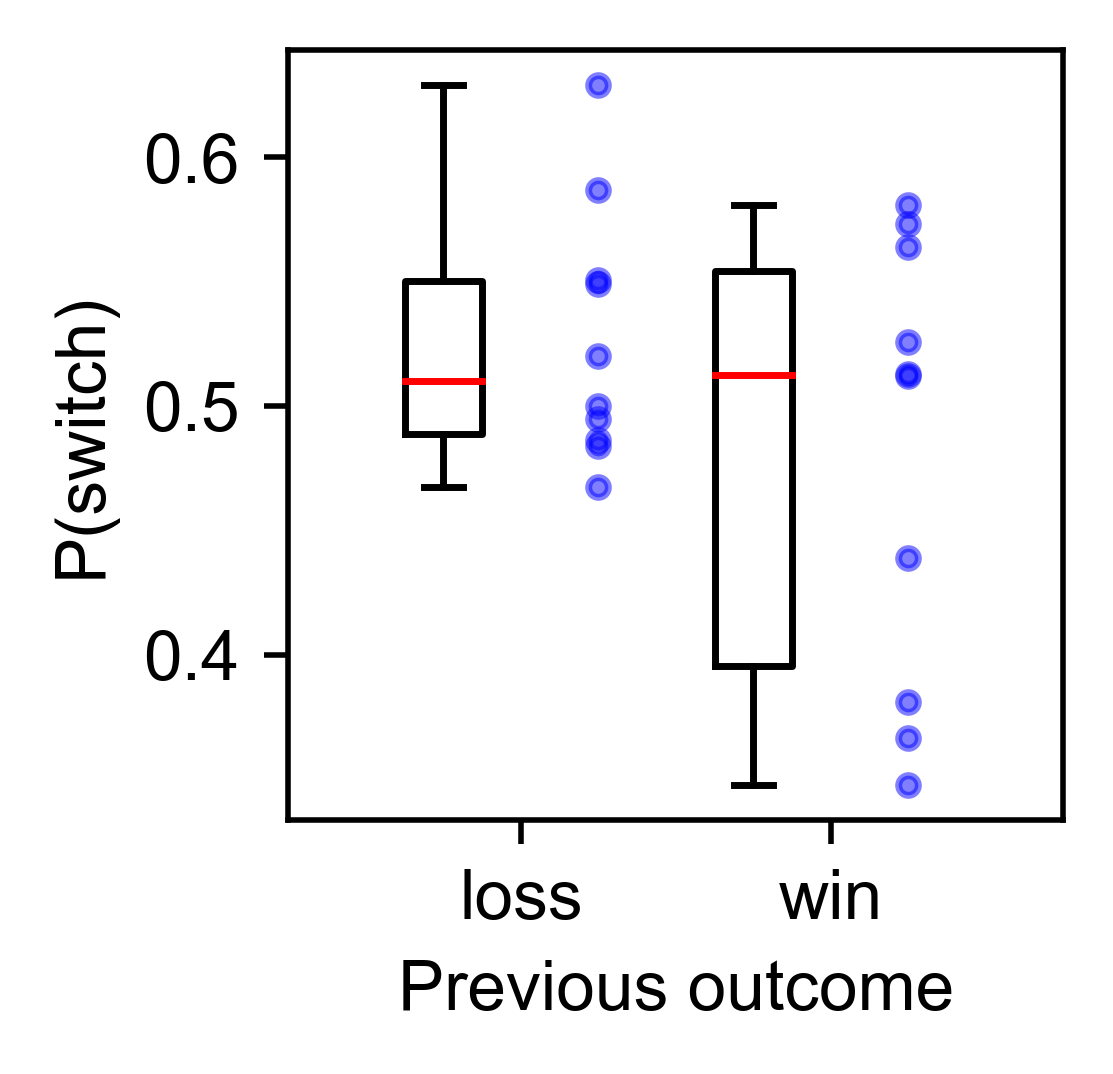

In [14]:
fig, ax = plt.subplots(figsize=(2,2), dpi=500)

ax.boxplot(loss_DF.switch, positions=[-0.2], 
           widths=0.05, showfliers=True, 
           boxprops=dict(color='black'),
           medianprops = dict(color='red'))

ax.scatter(x=np.ones(len(loss_DF)) * -0.1, y=loss_DF.switch, color='blue', s=8, alpha=0.5)
         
ax.boxplot(win_DF.switch, positions=[0], 
           widths=0.05, showfliers=True, 
           boxprops=dict(color='black'),
           medianprops = dict(color='red'))
ax.scatter(x=np.ones(len(win_DF)) * 0.1, y=win_DF.switch, color='blue', s=8, alpha=0.5)

ax.set_xticks([-0.15, 0.05]); 
ax.set_xticklabels(['loss','win'])
ax.yaxis.set_ticks(np.arange(0.4, 0.7, 0.1))
ax.set_xlim([-0.3, 0.2])
# ax.set_ylim([0.4, 0.6])
ax.set_ylabel('P(switch)')
ax.set_xlabel('Previous outcome')


fig.savefig(f'{outDir}/fig1_stayswitch.svg')

In [15]:
mod_guess = Lmer("guessLower ~ guessLower_L1 + guessLower_L2 + (1 + guessLower_L1 + guessLower_L2 |subID)", 
                data=groupData_L2, 
                family='binomial')
res_guess = mod_guess.fit()
display(res_guess)
# Format fixef into long-format for plotting 
mod_guess_fixef = mod_guess.fixef.iloc[:,1:]
mod_guess_fixef.columns = ['L1','L2']
mod_guess_long = pd.melt(mod_guess_fixef, id_vars=None, 
                      var_name='lag', 
                      value_name='coef')
mod_guess_long['mod'] = 'Guess'

/home/vman/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


boundary (singular) fit: see help('isSingular') 

               Estimate    2.5_ci   97.5_ci        SE        OR  OR_2.5_ci  \
(Intercept)   -0.031734 -0.298101  0.234634  0.135904  0.968765   0.742226   
guessLower_L1 -0.091980 -0.346223  0.162263  0.129718  0.912123   0.707355   
guessLower_L2  0.004738 -0.235066  0.244541  0.122351  1.004749   0.790519   

               OR_97.5_ci      Prob  Prob_2.5_ci  Prob_97.5_ci    Z-stat  \
(Intercept)      1.264446  0.492067     0.426022      0.558391 -0.233500   
guessLower_L1    1.176169  0.477021     0.414299      0.540477 -0.709077   
guessLower_L2    1.277035  0.501184     0.441503      0.560832  0.038723   

                  P-val Sig  
(Intercept)    0.815373      
guessLower_L1  0.478277      
guessLower_L2  0.969111      
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: guessLower~guessLower_L1+guessLower_L2+(1+guessLower_L1+guessLower_L2|subID)

Family: binomial	 Inference: parametric

Number of observations: 12

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.032,-0.298,0.235,0.136,0.969,0.742,1.264,0.492,0.426,0.558,-0.234,0.815,
guessLower_L1,-0.092,-0.346,0.162,0.130,0.912,0.707,1.176,0.477,0.414,0.540,-0.709,0.478,
guessLower_L2,0.005,-0.235,0.245,0.122,1.005,0.791,1.277,0.501,0.442,0.561,0.039,0.969,


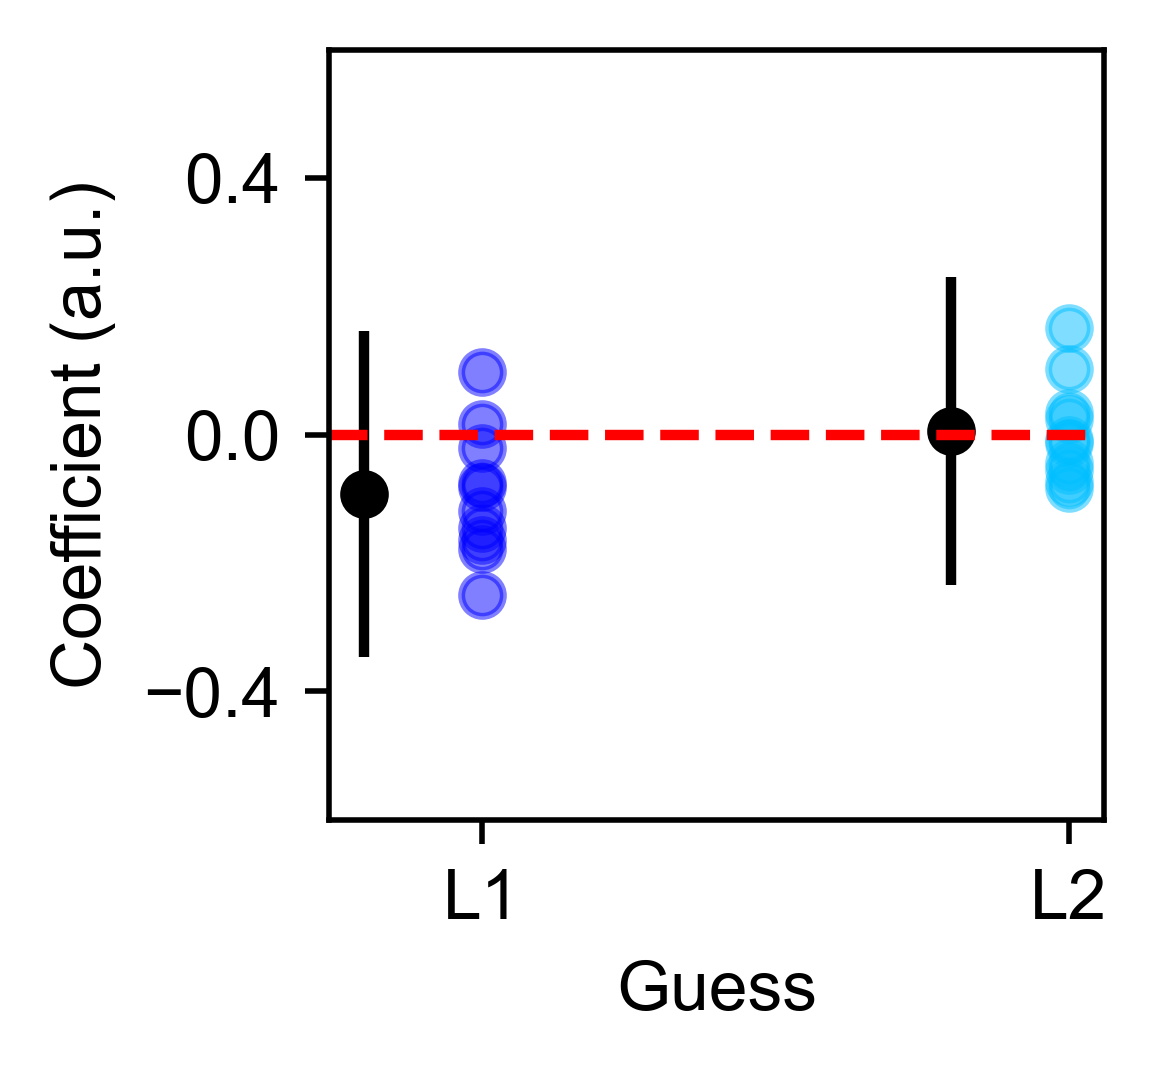

In [16]:
# Create array of lower and upper CI
mod_guess_CI = np.array([res_guess.Estimate[1:].values - res_guess['2.5_ci'][1:].values,
                     res_guess['97.5_ci'][1:].values - res_guess.Estimate[1:].values])


fig, ax = plt.subplots(figsize=(2,2), dpi=500, sharey=True)
ax.scatter(x=np.arange(2)-0.2, y=res_guess.Estimate[1:].values, color='black')
ax.errorbar(x = np.arange(2)-0.2, y = res_guess.Estimate[1:].values,
            yerr = mod_guess_CI,
             ls='none', color='black')
ax.scatter(x = np.ones(mod_guess.fixef.shape[0]) * 0, y=mod_guess.fixef['guessLower_L1'], color='blue', alpha=0.5)             
ax.scatter(x = np.ones(mod_guess.fixef.shape[0]), y=mod_guess.fixef['guessLower_L2'], color='deepskyblue', alpha=0.5 )             

ax.axhline(0,color='red',linestyle='--')
ax.set_ylabel('Coefficient (a.u.)')
ax.set_xlabel('Guess')
ax.set_ylim([-0.6,0.6])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['L1','L2'],fontsize=10)
ax.yaxis.set_major_locator(plt.MaxNLocator(3))

fig.savefig(f'{outDir}/fig1_AR_guess.svg')

In [17]:
mod_LR = Lmer("guessLRight ~ guessLRight_L1 + guessLRight_L2 + (1 + guessLRight_L1 + guessLRight_L2 |subID)", 
                data=groupData_L2, 
                family='binomial')
res_LR = mod_LR.fit()
display(res_LR)
# Format fixef into long-format for plotting 
mod_LR_fixef = mod_LR.fixef.iloc[:,1:]
mod_LR_fixef.columns = ['L1','L2']
mod_LR_long = pd.melt(mod_LR_fixef, id_vars=None, 
                      var_name='lag', 
                      value_name='coef')
mod_LR_long['mod'] = 'LR'

/home/vman/anaconda3/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


                Estimate    2.5_ci   97.5_ci        SE        OR  OR_2.5_ci  \
(Intercept)    -0.154457 -0.835890  0.526976  0.347676  0.856881   0.433489   
guessLRight_L1  0.181447 -0.488024  0.850917  0.341573  1.198951   0.613838   
guessLRight_L2  0.166013 -0.270338  0.602363  0.222632  1.180588   0.763122   

                OR_97.5_ci      Prob  Prob_2.5_ci  Prob_97.5_ci    Z-stat  \
(Intercept)       1.693803  0.461462     0.302401      0.628778 -0.444254   
guessLRight_L1    2.341793  0.545238     0.380359      0.700759  0.531209   
guessLRight_L2    1.826430  0.541408     0.432824      0.646197  0.745682   

                   P-val Sig  
(Intercept)     0.656859      
guessLRight_L1  0.595274      
guessLRight_L2  0.455859      
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: guessLRight~guessLRight_L1+guessLRight_L2+(1+guessLRight_L1+guessLRight_L2|subID)

Family: binomial	 Inference: parametric

Number of observations: 1277	 Groups: {'subID': 10.0}

Log-

,Estimate,2.5_ci,97.5_ci,SE,OR,OR_2.5_ci,OR_97.5_ci,Prob,Prob_2.5_ci,Prob_97.5_ci,Z-stat,P-val,Sig
(Intercept),-0.154,-0.836,0.527,0.348,0.857,0.433,1.694,0.461,0.302,0.629,-0.444,0.657,
guessLRight_L1,0.181,-0.488,0.851,0.342,1.199,0.614,2.342,0.545,0.380,0.701,0.531,0.595,
guessLRight_L2,0.166,-0.270,0.602,0.223,1.181,0.763,1.826,0.541,0.433,0.646,0.746,0.456,


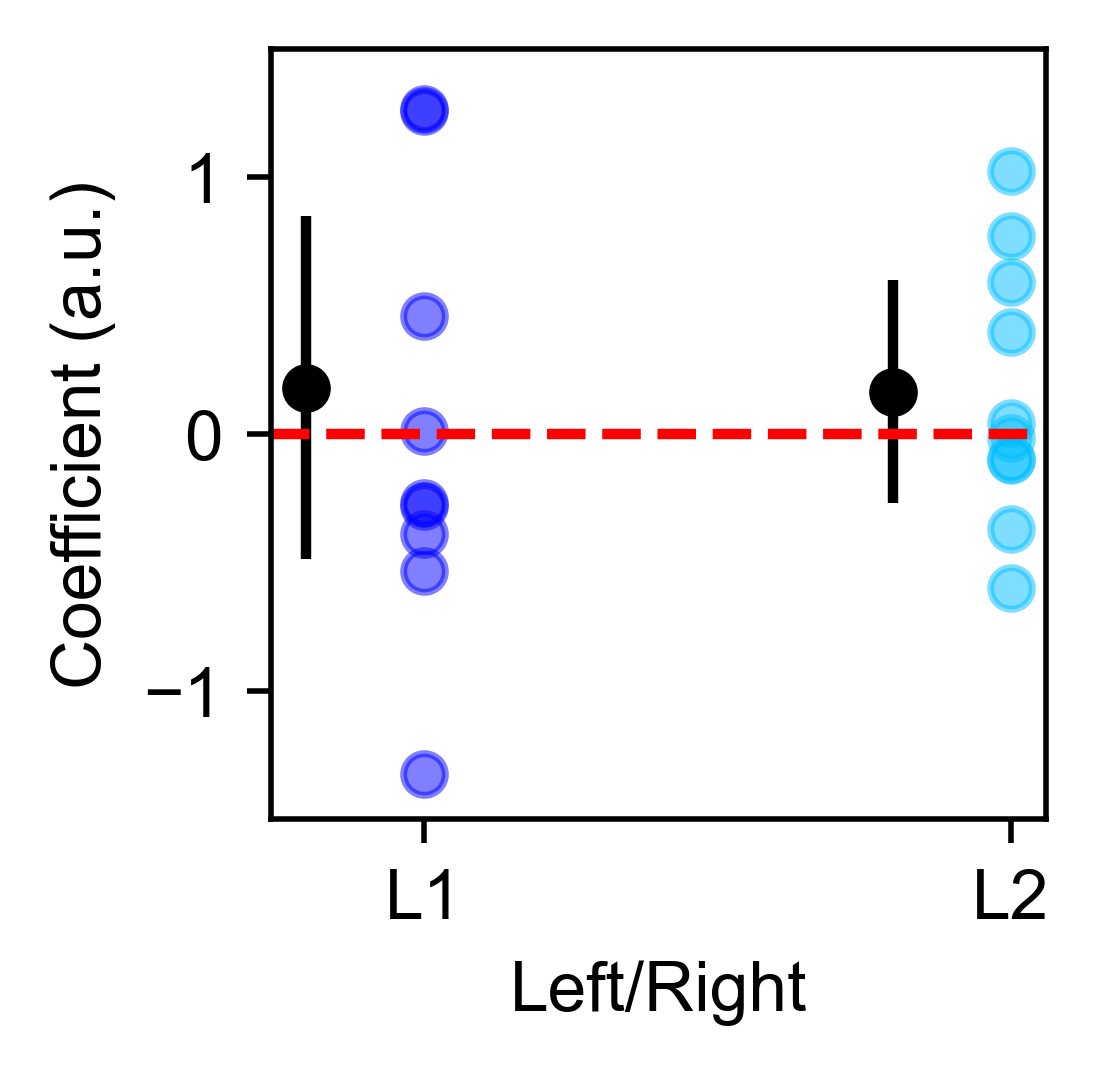

In [18]:
# Create array of lower and upper CI
mod_LR_CI = np.array([res_LR.Estimate[1:].values - res_LR['2.5_ci'][1:].values,
                     res_LR['97.5_ci'][1:].values - res_LR.Estimate[1:].values])


fig, ax = plt.subplots(figsize=(2,2), dpi=500, sharey=True)
ax.scatter(x=np.arange(2)-0.2, y=res_LR.Estimate[1:].values, color='black')
ax.errorbar(x = np.arange(2)-0.2, y = res_LR.Estimate[1:].values,
            yerr = mod_LR_CI,
             ls='none', color='black')
ax.scatter(x = np.ones(mod_LR.fixef.shape[0]) * 0, y=mod_LR.fixef['guessLRight_L1'], color='blue', alpha=0.5)             
ax.scatter(x = np.ones(mod_LR.fixef.shape[0]), y=mod_LR.fixef['guessLRight_L2'], color='deepskyblue', alpha=0.5 )             

ax.axhline(0,color='red',linestyle='--')
ax.set_ylabel('Coefficient (a.u.)')
ax.set_xlabel('Left/Right')
ax.set_ylim([-1.5,1.5])
ax.set_xticks(np.arange(2))
ax.set_xticklabels(['L1','L2'],fontsize=10)

fig.savefig(f'{outDir}/fig1_AR_LR.svg')